# Security Data Visualization:
## Presenting the sequence of alert signatures by source IP chronologically


In [1]:
import json
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import colormaps
import networkx as nx
import numpy as np
import pandas as pd
import pytz
from IPython.display import Image


In [2]:
SURICATA_ALERTS_DATA = "./suricata_alert/suricata_alert.json"

with open(SURICATA_ALERTS_DATA, "r") as fh:
    data = json.load(fh)

df = pd.json_normalize(data)

The raw dataframe from the `suricata_alert.json` has a nested, escaped json string inside _raw. Let's process that and combine it with our full dataframe.

In [3]:
df.head(10)

_bkt          _cd  _indextime  \
0  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63905046  1541287800   
1  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63904549  1541287799   
2  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12422475  1541287797   
3  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12422621  1541287798   
4  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12422083  1541287797   
5  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12420489  1541287795   
6  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12419981  1541287794   
7  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63900258  1541287792   
8  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63899364  1541287791   
9  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63899439  1541287791   

                                                _raw _serial             _si  \
0  {"timestamp":"2018-11-03T23:29:59.391761+0000"...       0  [index01, ids]   
1  {"timestamp":"2018-11-03T23:29:58.863966+0000"...       1  [index01, ids]   
2  {"timestamp":"2018-11-03T23:29:57.747162+0000"...       0  [index02, ids]   
3  {"timestamp":"2018-11-03T23:29:57.274596+0000"...       1  [index02, ids]   
4  {"timestamp":"2018-11-03T23:29:56.527419+0000"...       2  [index02, ids]   
5  {"timestamp":"2018-11-03T23:29:55.380276+0000"...       3  [index02, ids]   
6  {"timestamp":"2018-11-03T23:29:54.169878+0000"...       4  [index02, ids]   
7  {"timestamp":"2018-11-03T23:29:52.372600+0000"...       2  [index01, ids]   
8  {"timestamp":"2018-11-03T23:29:50.926465+0000"...       3  [index01, ids]   
9  {"timestamp":"2018-11-03T23:29:50.767183+0000"...       4  [index01, ids]   

  _subsecond                        _time                  host index  \
0    .391761  2018-11-03 23:29:59.391 UTC       t1-corp-mail-00   ids   
1    .863966  2018-11-03 23:29:58.863 UTC        t1-cars-car-87   ids   
2    .747162  2018-11-03 23:29:57.747 UTC        t1-cars-car-33   ids   
3    .274596  2018-11-03 23:29:57.274 UTC        t1-cars-car-18   ids   
4    .527419  2018-11-03 23:29:56.527 UTC    t1-prod-routing-00   ids   
5    .380276  2018-11-03 23:29:55.380 UTC        t1-cars-car-21   ids   
6    .169878  2018-11-03 23:29:54.169 UTC       t1-cars-car-114   ids   
7    .372600  2018-11-03 23:29:52.372 UTC  t1-prod-trackdash-00   ids   
8    .926465  2018-11-03 23:29:50.926 UTC       t1-cars-car-190   ids   
9    .767183  2018-11-03 23:29:50.767 UTC   t1-corp-security-00   ids   

  linecount                            source      sourcetype splunk_server  
0         1  /var/log/suricata/alert-json.log  suricata:alert       index01  
1         1  /var/log/suricata/alert-json.log  suricata:alert       index01  
2         1  /var/log/suricata/alert-json.log  suricata:alert       index02  
3         1  /var/log/suricata/alert-json.log  suricata:alert       index02  
4         1  /var/log/suricata/alert-json.log  suricata:alert       index02  
5         1  /var/log/suricata/alert-json.log  suricata:alert       index02  
6         1  /var/log/suricata/alert-json.log  suricata:alert       index02  
7         1  /var/log/suricata/alert-json.log  suricata:alert       index01  
8         1  /var/log/suricata/alert-json.log  suricata:alert       index01  
9         1  /var/log/suricata/alert-json.log  suricata:alert       index01

In [4]:
df = df.join(pd.json_normalize(df['_raw'].apply(eval)))

In [5]:
df.head(10)

_bkt          _cd  _indextime  \
0  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63905046  1541287800   
1  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63904549  1541287799   
2  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12422475  1541287797   
3  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12422621  1541287798   
4  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12422083  1541287797   
5  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12420489  1541287795   
6  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12419981  1541287794   
7  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63900258  1541287792   
8  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63899364  1541287791   
9  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63899439  1541287791   

                                                _raw _serial             _si  \
0  {"timestamp":"2018-11-03T23:29:59.391761+0000"...       0  [index01, ids]   
1  {"timestamp":"2018-11-03T23:29:58.863966+0000"...       1  [index01, ids]   
2  {"timestamp":"2018-11-03T23:29:57.747162+0000"...       0  [index02, ids]   
3  {"timestamp":"2018-11-03T23:29:57.274596+0000"...       1  [index02, ids]   
4  {"timestamp":"2018-11-03T23:29:56.527419+0000"...       2  [index02, ids]   
5  {"timestamp":"2018-11-03T23:29:55.380276+0000"...       3  [index02, ids]   
6  {"timestamp":"2018-11-03T23:29:54.169878+0000"...       4  [index02, ids]   
7  {"timestamp":"2018-11-03T23:29:52.372600+0000"...       2  [index01, ids]   
8  {"timestamp":"2018-11-03T23:29:50.926465+0000"...       3  [index01, ids]   
9  {"timestamp":"2018-11-03T23:29:50.767183+0000"...       4  [index01, ids]   

  _subsecond                        _time                  host index  ...  \
0    .391761  2018-11-03 23:29:59.391 UTC       t1-corp-mail-00   ids  ...   
1    .863966  2018-11-03 23:29:58.863 UTC        t1-cars-car-87   ids  ...   
2    .747162  2018-11-03 23:29:57.747 UTC        t1-cars-car-33   ids  ...   
3    .274596  2018-11-03 23:29:57.274 UTC        t1-cars-car-18   ids  ...   
4    .527419  2018-11-03 23:29:56.527 UTC    t1-prod-routing-00   ids  ...   
5    .380276  2018-11-03 23:29:55.380 UTC        t1-cars-car-21   ids  ...   
6    .169878  2018-11-03 23:29:54.169 UTC       t1-cars-car-114   ids  ...   
7    .372600  2018-11-03 23:29:52.372 UTC  t1-prod-trackdash-00   ids  ...   
8    .926465  2018-11-03 23:29:50.926 UTC       t1-cars-car-190   ids  ...   
9    .767183  2018-11-03 23:29:50.767 UTC   t1-corp-security-00   ids  ...   

  tls.issuerdn tls.serial tls.fingerprint tls.version tls.notbefore  \
0          NaN        NaN             NaN         NaN           NaN   
1          NaN        NaN             NaN         NaN           NaN   
2          NaN        NaN             NaN         NaN           NaN   
3          NaN        NaN             NaN         NaN           NaN   
4          NaN        NaN             NaN         NaN           NaN   
5          NaN        NaN             NaN         NaN           NaN   
6          NaN        NaN             NaN         NaN           NaN   
7          NaN        NaN             NaN         NaN           NaN   
8          NaN        NaN             NaN         NaN           NaN   
9          NaN        NaN             NaN         NaN           NaN   

   tls.notafter ssh.client.proto_version ssh.client.software_version  \
0           NaN                      NaN                         NaN   
1           NaN                      NaN                         NaN   
2           NaN                      NaN                         NaN   
3           NaN                      NaN                         NaN   
4           NaN                      NaN                         NaN   
5           NaN                      NaN                         NaN   
6           NaN                      NaN                         NaN   
7           NaN                      NaN                         NaN   
8           NaN                      NaN      

Some more data cleaning

In [6]:
# We want a unique identifier for each event. 
# This should probably be done on ingestion of the logs in Spark or Kafka,
# but let us just add an event_id column for convenience here
# Note that flow_id is not a unique identifier for all events listed
df["event_id"] = df.index.astype("string")


In [7]:
df.head(10)

_bkt          _cd  _indextime  \
0  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63905046  1541287800   
1  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63904549  1541287799   
2  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12422475  1541287797   
3  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12422621  1541287798   
4  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12422083  1541287797   
5  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12420489  1541287795   
6  ids~20~B135F5F1-8761-4D6B-9993-723ECD8DFAF7  20:12419981  1541287794   
7  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63900258  1541287792   
8  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63899364  1541287791   
9  ids~21~309B8BB8-F45C-44CE-ABE5-EF8B9EC8A780  21:63899439  1541287791   

                                                _raw _serial             _si  \
0  {"timestamp":"2018-11-03T23:29:59.391761+0000"...       0  [index01, ids]   
1  {"timestamp":"2018-11-03T23:29:58.863966+0000"...       1  [index01, ids]   
2  {"timestamp":"2018-11-03T23:29:57.747162+0000"...       0  [index02, ids]   
3  {"timestamp":"2018-11-03T23:29:57.274596+0000"...       1  [index02, ids]   
4  {"timestamp":"2018-11-03T23:29:56.527419+0000"...       2  [index02, ids]   
5  {"timestamp":"2018-11-03T23:29:55.380276+0000"...       3  [index02, ids]   
6  {"timestamp":"2018-11-03T23:29:54.169878+0000"...       4  [index02, ids]   
7  {"timestamp":"2018-11-03T23:29:52.372600+0000"...       2  [index01, ids]   
8  {"timestamp":"2018-11-03T23:29:50.926465+0000"...       3  [index01, ids]   
9  {"timestamp":"2018-11-03T23:29:50.767183+0000"...       4  [index01, ids]   

  _subsecond                        _time                  host index  ...  \
0    .391761  2018-11-03 23:29:59.391 UTC       t1-corp-mail-00   ids  ...   
1    .863966  2018-11-03 23:29:58.863 UTC        t1-cars-car-87   ids  ...   
2    .747162  2018-11-03 23:29:57.747 UTC        t1-cars-car-33   ids  ...   
3    .274596  2018-11-03 23:29:57.274 UTC        t1-cars-car-18   ids  ...   
4    .527419  2018-11-03 23:29:56.527 UTC    t1-prod-routing-00   ids  ...   
5    .380276  2018-11-03 23:29:55.380 UTC        t1-cars-car-21   ids  ...   
6    .169878  2018-11-03 23:29:54.169 UTC       t1-cars-car-114   ids  ...   
7    .372600  2018-11-03 23:29:52.372 UTC  t1-prod-trackdash-00   ids  ...   
8    .926465  2018-11-03 23:29:50.926 UTC       t1-cars-car-190   ids  ...   
9    .767183  2018-11-03 23:29:50.767 UTC   t1-corp-security-00   ids  ...   

  tls.serial tls.fingerprint tls.version tls.notbefore tls.notafter  \
0        NaN             NaN         NaN           NaN          NaN   
1        NaN             NaN         NaN           NaN          NaN   
2        NaN             NaN         NaN           NaN          NaN   
3        NaN             NaN         NaN           NaN          NaN   
4        NaN             NaN         NaN           NaN          NaN   
5        NaN             NaN         NaN           NaN          NaN   
6        NaN             NaN         NaN           NaN          NaN   
7        NaN             NaN         NaN           NaN          NaN   
8        NaN             NaN         NaN           NaN          NaN   
9        NaN             NaN         NaN           NaN          NaN   

   ssh.client.proto_version ssh.client.software_version  \
0                       NaN                         NaN   
1                       NaN                         NaN   
2                       NaN                         NaN   
3                       NaN                         NaN   
4                       NaN                         NaN   
5                       NaN                         NaN   
6                       NaN                         NaN   
7                       NaN                         NaN   
8                       NaN                         NaN   
9                       NaN                         NaN   

  ssh.server.proto_version ssh.server.softwa

Because this data is a series of `src_ip`s spawning some security events with a `dest_ip` attached to it, it makes sense to store this information in a graph. There are several ways that this can be done. However, our problem is to visually present the sequence of alert signatures generated by a source IP chronologically. So, we should have a graph with two types of nodes, `ip_node`s and `event_node`s. `ip_node`s are only connected to `event_node`s with a directed edge, with the direction indicating whether the event is pointing to a `dest_ip` or a `src_ip` is pointing to an event. `event_node`s for a specific `src_ip` `ip_node` are also sorted chronologically and chained together like a linked list. 

In [8]:
def row_to_alert_dict(row):
    # Filters down the pd dataframe to only the columns we care about

    keys = [
        "timestamp",
        "src_ip",
        "src_port",
        "dest_ip",
        "dest_port",
        "alert.signature",
        "alert.category",
        "alert.severity",
        "event_id"
    ]
    
    return {key:value for key, value in row.items() if key in keys}

In [9]:
def find_latest_event_before_timestamp(event_graph, source_node, threshold_timestamp):
    # Finds the NEWEST event node with a timestamp OLDER than the threshold
    try:
        current_event_timestamp = datetime.fromisoformat(event_graph.nodes[source_node]["timestamp"])
    except KeyError:
        # ip_nodes do not have a timestamp field (yet)
        current_event_timestamp = pytz.utc.localize(datetime.min)
    
    if current_event_timestamp > threshold_timestamp:
        return source_node
    else:
        next_nodes = event_graph.successors(source_node)
        for node in next_nodes:
            if event_graph.nodes[node]["is_event"]:
                return find_latest_event_before_timestamp(event_graph, node, threshold_timestamp)
        else:
            # No event is after this
            return source_node
                

In [10]:
def add_node_between_events(event_graph, event_node, predecessor_node):
    # Adds the event node after a predecessor node. If the predecessor node
    # has successor nodes, the event node becomes the new successor node and 
    # inherits the successors of the predecessor
    
    successor_event_node = None
    for successor_node in event_graph.successors(predecessor_node):
        if event_graph.nodes[successor_node]["is_event"]:
            successor_event_node = successor_node
            break
    else:
        # No successor event node
        successor_event_node = None
    
    if successor_event_node:
        event_graph.remove_edge(predecessor_node, successor_event_node)
        event_graph.add_edge(predecessor_node, event_node)
        event_graph.add_edge(event_node, successor_event_node)
    else:
        event_graph.add_edge(predecessor_node, event_node)
    

I previously tried using a unique `ip_node` per `dest_ip` and have every `event_node` that references the `dest_ip` have a directed edge pointing towards that `dest_ip` `ip_node`. However, this caused the resulting visual representation to be extremely cluttered and have thousands of overlapping edges.    

```event_graph.add_node(dest_ip, label=dest_ip, is_ip=True, is_event=False, dest=True)```

Because of this, instead of a unique `ip_node` per `dest_ip`, we have a duplicated `ip_node` with a `dest_ip` label corresponding to each `event_node`. This allows us to have a visualization with very short local edges that represent the chronological dependencies in the graph that also do not cross with the network flow graph edges. 

In [11]:
source_ips = df["src_ip"].unique()

event_graph = nx.DiGraph()

# We want to have two types of nodes. 
# ip_nodes represent actors in the system
# event_nodes represent events that the predecessor ip_node acted upon the successor ip_node (directed edge)

for source_ip in source_ips:
    for index, row in df[df["src_ip"] == source_ip].iterrows():
        row_dict = row_to_alert_dict(row)
        dest_ip = row["dest_ip"]
        # Flow_id does not appear to be unique, use flow_id + timestamp 
        event_id = row["event_id"]
        event_label = row["alert.signature"]
        event_time = datetime.fromisoformat(row["timestamp"])
        
        ip_label_format = "{ip}:{port:.0f}" # The dataframe casted port into a float64, drop the trailing zeros 
        
        event_graph.add_node(
            source_ip, 
            label=ip_label_format.format(ip=source_ip, port=row["src_port"]), 
            is_ip=True, 
            is_event=False, 
            src=True
        )
        # This would have one unique dest_ip_node for all references to this node. However,
        # in a 2D representation of the graph, there are too many lines that connect event_nodes
        # to the few unique dest_ip_nodes which makes it unreadable. 
        #event_graph.add_node(dest_ip, label=dest_ip, is_ip=True, is_event=False, dest=True)
        
        # Instead, we duplicate this dest_ip_node as many times as there are event_nodes pointing
        # to them. Thus, we need a new key for this
        dest_ip_node_id = f"{dest_ip}_{event_id}"
        event_graph.add_node(
            dest_ip_node_id, 
            label=ip_label_format.format(ip=dest_ip, port=row["dest_port"]), 
            is_ip=True, 
            is_event=False, 
            src=False
        )
        
        event_graph.add_node(
            event_id, 
            label=event_label, 
            is_ip=False, 
            is_event=True, 
            **row_dict # Everything else described in the event row
        )
        
        # Walk through the event node successors of source_ip and find the latest event
        # with an earlier timestamp than this event
        predecessor_event = find_latest_event_before_timestamp(event_graph, source_ip, event_time)

        add_node_between_events(event_graph, event_id, predecessor_event)
        #event_graph.add_edge(event_id, dest_ip)
        event_graph.add_edge(event_id, dest_ip_node_id)
        
    print(f"Finished source_ip {source_ip}")


Finished source_ip 10.0.0.22
Finished source_ip 10.0.47.87
Finished source_ip 10.0.47.33
Finished source_ip 10.0.47.18
Finished source_ip 10.0.1.42
Finished source_ip 10.0.47.21
Finished source_ip 10.0.47.114
Finished source_ip 10.0.1.46
Finished source_ip 10.0.47.190
Finished source_ip 10.0.0.24
Finished source_ip 10.0.1.40
Finished source_ip 10.0.0.244
Finished source_ip 10.0.1.44
Finished source_ip 10.0.1.43
Finished source_ip 10.0.1.5
Finished source_ip 10.0.0.243
Finished source_ip 10.0.1.53
Finished source_ip 10.0.1.54
Finished source_ip 10.0.1.51
Finished source_ip 10.0.0.11
Finished source_ip 10.0.1.41
Finished source_ip 10.0.47.128
Finished source_ip 10.0.0.176
Finished source_ip 10.0.0.20
Finished source_ip 10.0.1.52
Finished source_ip 10.0.47.177
Finished source_ip 10.0.47.136
Finished source_ip 10.0.254.202
Finished source_ip 10.0.254.206
Finished source_ip 10.0.254.104
Finished source_ip 10.0.254.105
Finished source_ip 10.0.254.103
Finished source_ip 10.0.254.205
Finished 

In [12]:
def dfs_edges(event_graph, source_node):
    # Returns all edges in the DAG from the source node to all successor nodes, terminating at dest_ip_nodes
    successors = event_graph.successors(source_node)
    
    edge_list = []
    for successor in successors:
        edge_list.append((source_node, successor))
        if event_graph.nodes[successor].get("is_event", False):
            edge_list.append((source_node, successor))
            edge_list.extend(dfs_edges(event_graph, successor))
    return edge_list
            

In [13]:
def bfs_nodes(event_graph, source_node):
    # Returns all nodes in the DAG from the source node to all successor nodes, terminating at dest_ip_nodes
    # Not technically a true BFS because we leverage the fact that our graph does not have any event_nodes 
    # that connect to dest_id_nodes
    
    successors = event_graph.successors(source_node)
    
    dest_ip_nodes = []
    event_nodes = []
    
    for successor in successors:
        if event_graph.nodes[successor]["is_event"]:
            event_nodes.append(successor)
        else:
            dest_ip_nodes.append(successor)
    
    if event_nodes:
        successor_ip_nodes, successor_event_nodes = bfs_nodes(event_graph, event_nodes[-1])
        event_nodes.extend(successor_event_nodes)
        dest_ip_nodes.extend(successor_ip_nodes)
    
    return (dest_ip_nodes, event_nodes)

While `networkx` is a decent python package for creating graphs of various types and running a multitude of graph algorithms on it, its weak point is definitely visualization. I tried all of their layout generators on this incredibly large graph and there would constantly be hyper-clustering of nodes with occasional extremely lengthy edges connecting the clusters. In other cases, it would disregard any attempt at minimizing edge intersections and simply lay the nodes at random points on a circle. None of these representations are useful in identifying the chronological nature of these events. 

Thus, I designed my own custom layout using the simple mathematical formula for a spiral `r(theta) = w * (theta + c)` where `w` and `c` are parameters to scale accordingly. `event_node`s are mapped to the spiral, with fewer events near the center to reduce cluttering, and the chronological ordering can be enforced.

In [14]:
def polar_to_cartesian(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

In [15]:
def generate_custom_layout(subgraph, source_ip):
    
    # Get the nodes, ordered by traversal
    dest_ip_nodes, event_nodes = bfs_nodes(subgraph, source_ip)
    layout = nx.planar_layout(subgraph)
    
    # We want w=5 rotations around the spiral
    w = 5
    for node_type_offset, node_list_type in enumerate([event_nodes, dest_ip_nodes]):
    
        # Let's say 2% of the data within theta = 2pi, 8% within 2pi< theta < 4pi, 
        # and so on for 16%, 32%, 42%
        thresholds = np.floor(np.array([0.02, 0.08, 0.16, 0.32, 0.42]) * len(node_list_type)).astype(int)
        thresholds[-1] = len(node_list_type) - np.sum(thresholds[:-1])
        thetas = []
        
        for index, threshold in enumerate(thresholds):
            # Linspace one additional term and drop it because the next node would be located at 2pi*index
            # We do not want overlap
            thetas.append((np.linspace(0, 2 * np.pi, threshold+1) + index * 2 * np.pi)[:-1])
        
        thetas = np.concatenate(thetas, axis=0)
        
        for index in range(len(thetas)):
            # R = w(theta + c)
            offset_constant = 2 # Scale this appropriately
            radius = w * (thetas[index] + node_type_offset * offset_constant) # Offset the nodes outwards by a small amount for each successive node type
            layout[node_list_type[index]] = polar_to_cartesian(radius, thetas[index])
        
        layout[source_ip] = np.array([-np.pi, 0])
    return layout
    

Finally, we also want to colour-code the severity of alerts. It is incredibly helpful at a glance to immediately see whether something is critically important or just a small point of interest. In every system I have seen, timestamps are by far the worst to handle (due to inconsistencies, improper setup of devices/environments/agents, timezones, daylight savings, network latency, ingest time vs process time vs log time vs ...). However, alert severity is definitely a close second. There is no commonly agreed-upon standard here of whether higher = more severe or lower = more severe.  

In [16]:
# It appears that alert severity is between 1-3 with 1 being the highest and 3 being the lowest
df[df["alert.severity"] == 3].head(5)[["alert.signature", "alert.category", "alert.severity"]]

alert.signature  \
7345                             GPL ICMP_INFO PING *NIX   
7347                             GPL ICMP_INFO PING *NIX   
16100  ET INFO WinHttp AutoProxy Request wpad.dat Pos...   
16105  ET INFO WinHttp AutoProxy Request wpad.dat Pos...   
24208  ET INFO WinHttp AutoProxy Request wpad.dat Pos...   

                        alert.category  alert.severity  
7345                     Misc activity               3  
7347                     Misc activity               3  
16100  Generic Protocol Command Decode               3  
16105  Generic Protocol Command Decode               3  
24208  Generic Protocol Command Decode               3

In [17]:
df[df["alert.severity"] == 1].head(5)[["alert.signature", "alert.category", "alert.severity"]]

alert.signature  \
1531  ET POLICY Incoming Basic Auth Base64 HTTP Pass...   
1532  ET POLICY Outgoing Basic Auth Base64 HTTP Pass...   
1538  ET POLICY Incoming Basic Auth Base64 HTTP Pass...   
1539  ET POLICY Outgoing Basic Auth Base64 HTTP Pass...   
2255  ET POLICY Incoming Basic Auth Base64 HTTP Pass...   

                             alert.category  alert.severity  
1531  Potential Corporate Privacy Violation               1  
1532  Potential Corporate Privacy Violation               1  
1538  Potential Corporate Privacy Violation               1  
1539  Potential Corporate Privacy Violation               1  
2255  Potential Corporate Privacy Violation               1

In [18]:
def view_subgraph(event_graph, source_ip):
    colour_map_severity = {
        1: "red",
        2: "orange",
        3: "yellow",
    }
    colour_map_is_src_ip = {
        True: "blue",
        False: "gray",
    }
    
    
    if "src" in event_graph.nodes[source_ip].keys():
        print(f"Subgraph for Source IP: {source_ip}")
        edge_list = dfs_edges(event_graph, source_ip)       
        subgraph = event_graph.edge_subgraph(edge_list)
        
        pos = generate_custom_layout(subgraph, source_ip)
        plt.figure(1, figsize=(100,100))
        nx.draw_networkx_nodes(
            subgraph, 
            pos=pos,
            node_color=[
                colour_map_severity[
                    node[1]["alert.severity"]
                ]
                if node[1].get("event_id", None) is not None 
                else colour_map_is_src_ip[
                    node[1]["src"]
                ] 
                for node in subgraph.nodes(data=True)
            ],
            node_size=800
        )
        nx.draw_networkx_labels(
            subgraph, 
            pos=pos,
            labels={
                node[0]: node[1]["label"]
                for node in subgraph.nodes(data=True)
            }
        )
        nx.draw_networkx_edges(
            subgraph, 
            pos=pos,
            width=3,
            arrowsize=20,
        )
        plt.show()
        
    

We can finally build a view of our subgraph!

In [19]:
view_subgraph(event_graph, "10.0.0.23")

Subgraph for Source IP: 10.0.0.23


In [20]:
# Image("alert_sig_chronological_10_0_0_23.png")  # A copy of the subgraph view is also stored here 

## Visualizing Source IP to Destination IP and Port interactions

We can leverage a very similar graph structure to the previous part 

In [21]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

In [22]:
ip_groupby = df.groupby(["src_ip", "dest_ip", "dest_port"]).agg({"dest_port": ["count"], "timestamp": ["min", "max"]})
ip_groupby.reset_index(inplace=True)
ip_groupby.columns = ["src_ip", "dest_ip", "dest_port", "count", "oldest_timestamp", "latest_timestamp"]
ip_groupby

src_ip          dest_ip  dest_port  count  \
0         10.0.0.11     10.0.254.202    47911.0      1   
1         10.0.0.11      147.75.40.2       80.0      2   
2         10.0.0.11  169.254.169.254       80.0   1529   
3        10.0.0.176      147.75.40.2       80.0      2   
4        10.0.0.176  169.254.169.254       80.0   1610   
...             ...              ...        ...    ...   
1439     10.0.47.87   35.203.168.189       80.0      3   
1440     10.0.47.87     91.189.91.26       80.0      1   
1441     10.0.47.87    91.189.92.191       80.0      1   
1442     10.0.47.87     91.189.95.83       80.0      1   
1443  104.198.8.242        10.0.0.24       22.0      1   

                     oldest_timestamp                 latest_timestamp  
0    2018-11-03 21:08:00.667929+00:00 2018-11-03 21:08:00.667929+00:00  
1    2018-11-03 21:47:20.460052+00:00 2018-11-03 21:47:20.460052+00:00  
2    2018-11-03 13:38:38.584363+00:00 2018-11-03 23:29:46.601979+00:00  
3    2018-11-03 21:47:20.548047+00:00 2018-11-03 21:47:20.548047+00:00  
4    2018-11-03 13:37:33.773345+00:00 2018-11-03 23:29:44.766520+00:00  
...                               ...                              ...  
1439 2018-11-03 19:50:43.996785+00:00 2018-11-03 19:51:45.001604+00:00  
1440 2018-11-03 19:50:44.136087+00:00 2018-11-03 19:50:44.136087+00:00  
1441 2018-11-03 19:50:44.266478+00:00 2018-11-03 19:50:44.266478+00:00  
1442 2018-11-03 19:50:44.271925+00:00 2018-11-03 19:50:44.271925+00:00  
1443 2018-11-03 13:36:01.786615+00:00 2018-11-03 13:36:01.786615+00:00  

[1444 rows x 6 columns]

In [23]:
source_ips = ip_groupby["src_ip"].unique()

ip_graph = nx.DiGraph()

for source_ip in source_ips:
    for index, row in ip_groupby[ip_groupby["src_ip"] == source_ip].iterrows():
        ip_graph.add_node(
            source_ip, 
            src=True
        )
        
        ip_graph.add_node(
            "{dest_ip}:{dest_port:.0f}".format(dest_ip=row["dest_ip"], dest_port=row["dest_port"]), 
            dest=True
        )
        
        ip_graph.add_edge(
            source_ip, 
            "{dest_ip}:{dest_port:.0f}".format(dest_ip=row["dest_ip"], dest_port=row["dest_port"]),
            **row
        )
        
    print(f"Finished source_ip {source_ip}")

Finished source_ip 10.0.0.11
Finished source_ip 10.0.0.176
Finished source_ip 10.0.0.20
Finished source_ip 10.0.0.22
Finished source_ip 10.0.0.23
Finished source_ip 10.0.0.24
Finished source_ip 10.0.0.243
Finished source_ip 10.0.0.244
Finished source_ip 10.0.1.40
Finished source_ip 10.0.1.41
Finished source_ip 10.0.1.42
Finished source_ip 10.0.1.43
Finished source_ip 10.0.1.44
Finished source_ip 10.0.1.46
Finished source_ip 10.0.1.5
Finished source_ip 10.0.1.51
Finished source_ip 10.0.1.52
Finished source_ip 10.0.1.53
Finished source_ip 10.0.1.54
Finished source_ip 10.0.254.101
Finished source_ip 10.0.254.103
Finished source_ip 10.0.254.104
Finished source_ip 10.0.254.105
Finished source_ip 10.0.254.106
Finished source_ip 10.0.254.202
Finished source_ip 10.0.254.203
Finished source_ip 10.0.254.204
Finished source_ip 10.0.254.205
Finished source_ip 10.0.254.206
Finished source_ip 10.0.47.114
Finished source_ip 10.0.47.128
Finished source_ip 10.0.47.136
Finished source_ip 10.0.47.177
Fin

In [24]:
# We want to scale our edge sizes to match the largest event count
max_event_count = ip_groupby["count"].max()

In [25]:
def view_ip_subgraph(ip_graph, source_ip, edge_scaling=100):
    edge_list = dfs_edges(ip_graph, source_ip)
    subgraph = ip_graph.edge_subgraph(edge_list)
    
    pos = nx.planar_layout(subgraph)
    plt.figure(1, figsize=(20,20))
    nx.draw_networkx_nodes(
        subgraph,
        pos=pos,
        node_size=800
    )
    nx.draw_networkx_labels(
        subgraph,
        pos=pos,
    )
    
    min_edge_size = 2
    max_edge_size = 50
    nx.draw_networkx_edges(
        subgraph,
        pos=pos,
        edge_cmap=colormaps.get_cmap("cool"),
        edge_color=[
            edge[2]["latest_timestamp"].timestamp()
            for edge in subgraph.edges(data=True)
        ],
        width=[
            (int(edge[2]["count"])/edge_scaling) * max_edge_size + min_edge_size
            for edge in subgraph.edges(data=True)
        ],
        arrowsize=20,
    )
    plt.show()

We use a colour map on edges to represent the latest `timestamp` seen for an event that connects the `src_ip` `ip_node` to the `dest_ip` `ip_node`. This is scaled in accordance to all the other `timestamps` seen in events where the source ip was `src_ip` `ip_node` (for cmap("cool"), cyan edges show very old `timestamp_latest` while pink edges show very recent `timestamp_latest`). We also scale the thickness of the edge in correspondence to the volume of events directed from `src_ip` `ip_node` to `dest_ip` `ip_node`. 

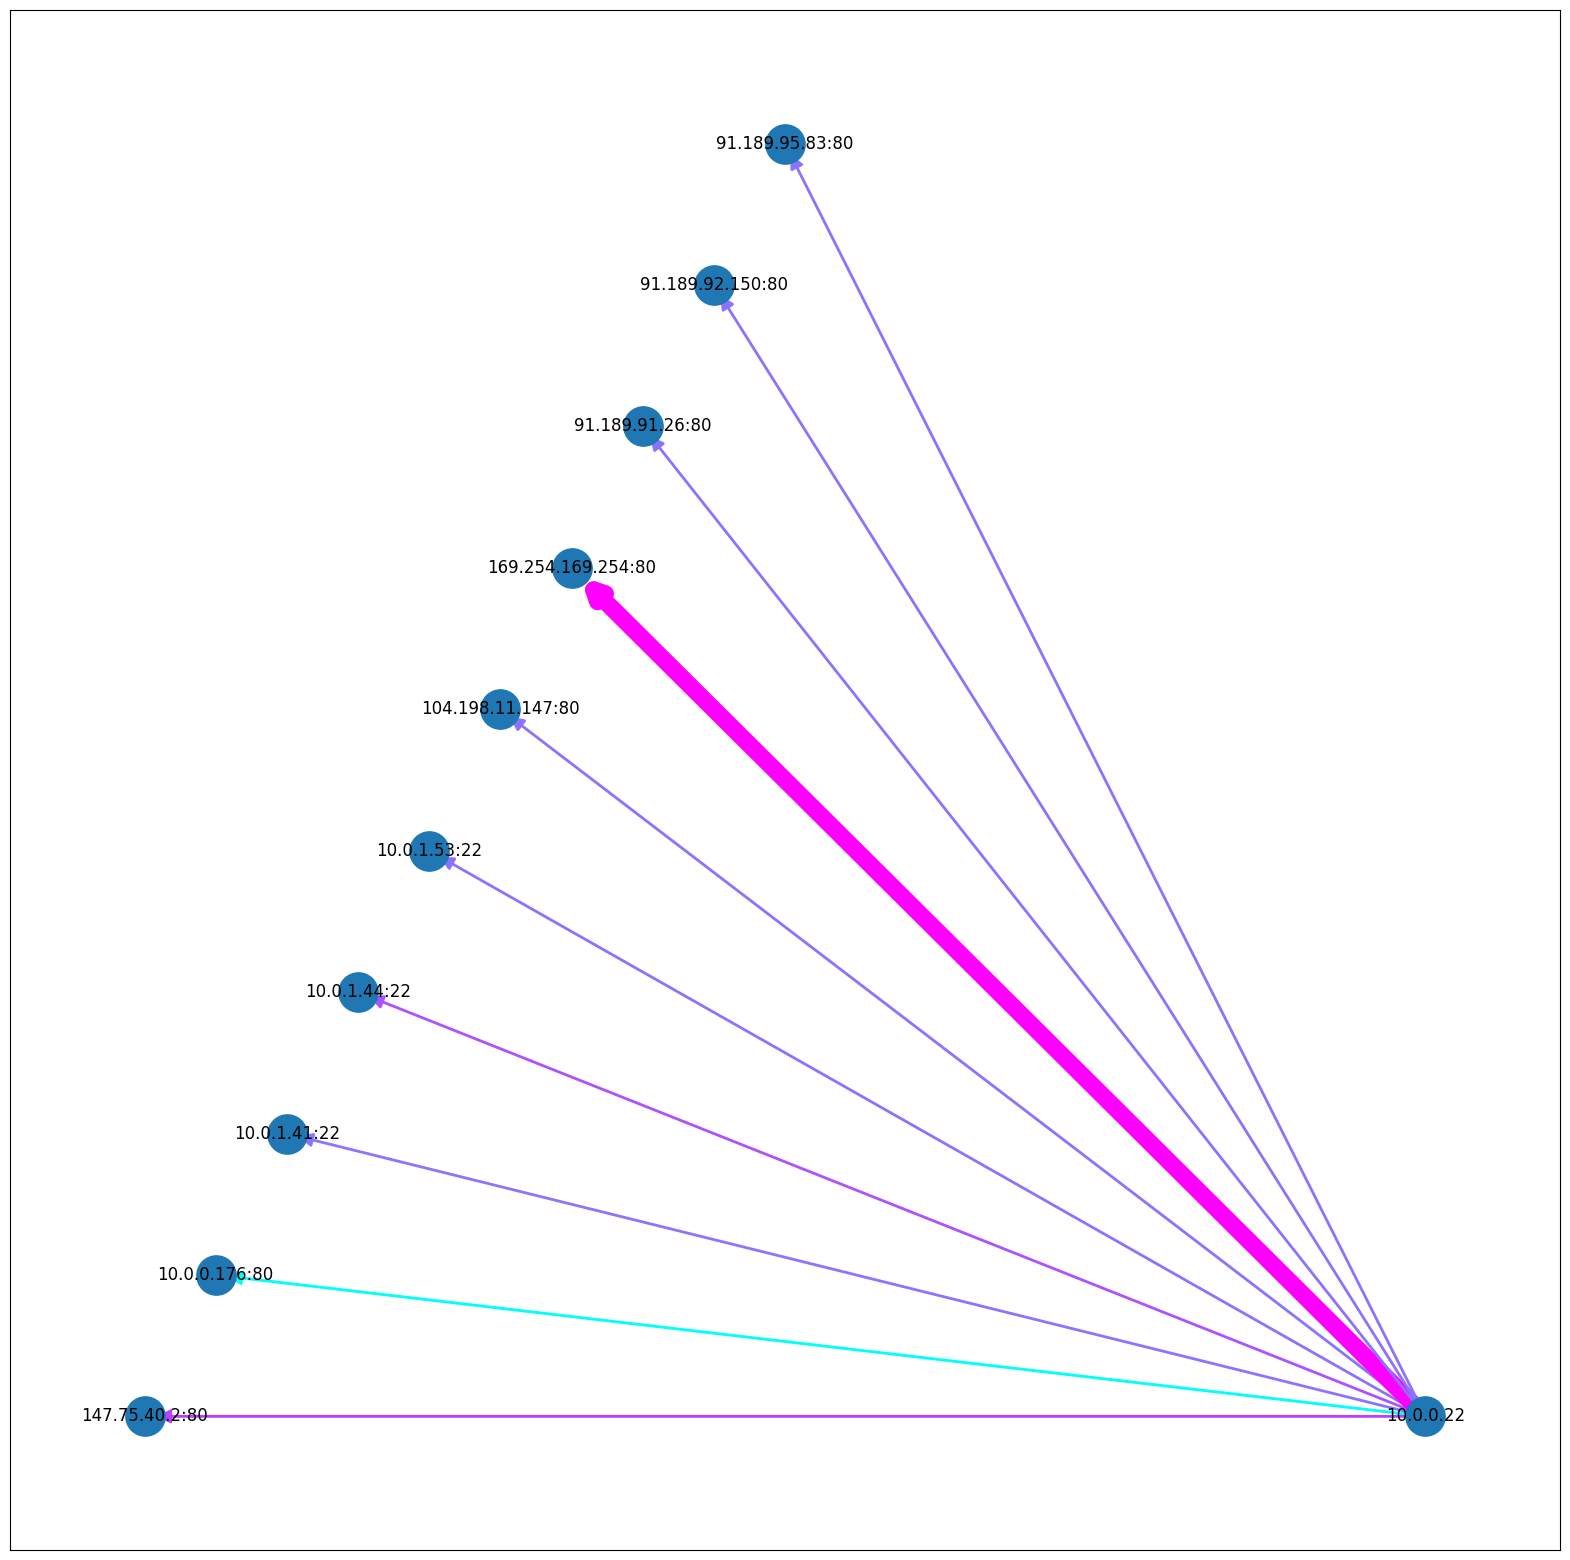

In [26]:
view_ip_subgraph(ip_graph, "10.0.0.22", edge_scaling=max_event_count)

In [27]:
# Image("ip_interactions_10_0_0_22.png")

## Discussion
1. How could you enhance these visualizations with additional time and resources?

With additional time, I would fix a few of the cluttering problems in the current visualisation and also add potential interactivity with this graph. There are some issues with the readability of the labels that I would like to fix (for example, line wrapping and scaling). However, I believe that many of these should be solved using another way instead. By using a library like `plotly`, we can have interactive network graphs instead. Due to this interactivity, we could nest node labels under on-hover actions and have node or edge attributes nested under on-click actions. Furthermore, a dedicated graphing library like `plotly` would have much better support for handling drawing graphs (static or interactive) compared to the robust but austere look of `networkx` graphs. 

However, an important point to consider is network traffic volume. Any graphing library would get overwhelmed with the full volume of network communication traffic passed to it in log form. Thus, it would make sense to have something like Kafka ingesting raw logs into an S3 bucket, Spark/Flink to process normalization and enhancement of the logs into a highly available database like MongoDB, some microservice to query the database and build a static versioned subgraph with `networkx`, and then a user querying the subgraph to build a smaller interactive sub-subgraph using `plotly`. In fact, running the code to generate a `networkx` static subgraph took a few seconds but even rendering the full image on my screen took longer than that. An interactive display of the full network graph would stand no chance at actually finishing drawing one frame. 

Thus, I believe that these static `networkx` graphs are still important for snapshotting and understanding general network flow and traffic while interactive `plotly` graphs would be more suited for actual investigative work. `networkx` offers an incredibly robust and fast way to manipulate graph data as well as a compendium of algorithms for graph analytics while `plotly` offers more intuitive techniques for visualising and interactively manipulating a subgraph (especially for a non-technical expert).  

2. How would you evaluate the effectiveness of these visualizations?

While it would be nice to have surveys of users to get quick and easy feedback, this is a very naive approach. Instead, we could track several metrics on how a person uses this visualization to complete their task. Metrics such as time spent on task, number of clicks, time spent backtracking, and database hit rate could all be indicative of the effectiveness of this visualization (for interactive graphs). From my time spent working on backend systems supporting security analysts, I found that the most temperamental system were the ElasticSearch nodes that the SoC team would run queries against. Every 2-8 days, a query or a script would hit an extremely large number of shards, causing many of them to hang and effectively crashing the whole system until someone restarted the deployments. With proper graph analytic tools and versioning of subgraphs (and smart subgraph creation algorithms based on SoC search patterns), the amount of large search queries would likely be greatly reduced. Thus, I also propose that we can measure the effectiveness of these visualizations by looking at the performance and uptime of the backend systems and infrastructure that support the SoC teams. 